## Flow
- Linear Regression 끄적여보기
- [1차 Modeling](#2.-1차-Modeling)
- [2차 Modeling](#2차-Modeling)

### 1. 선형회귀(Linear Regression) 끄적여보기

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv("../dataset/train.csv")
y_train = df['price']
x_train = df.drop(columns=['price'])
x_train.shape, y_train.shape

((15035, 20), (15035,))

In [34]:
df_test = pd.read_csv("../dataset/test.csv")
df_test.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [35]:
df_test['date'] = df_test['date'].map(lambda x: int(x.split('T')[0]))
df_test['date'].min()

20140502

### 기본 선형모델(feature를 추가하지 않은)
- feature drop
    - id, date, zipcode (drop)
- OLS

In [7]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + C(waterfront) \
                    + view + condition + grade + sqft_above + sqft_basement + yr_built \
                    + yr_renovated + lat + long + sqft_living15 + sqft_lot15 - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3131.
Date:                Tue, 02 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:13:29   Log-Likelihood:                -689.49
No. Observations:               15035   AIC:                             1413.
Df Residuals:                   15018   BIC:                             1542.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(waterfront)[0]   -52.4150      2.389  

- price보다 np.log1p(price)를 해주는게 R square가 높다..
- condition number가 너무 크다.

1. std err : 표준오차(standard error) ; 
2. t : (w_hat - w) / std_err = t
3. p>|t| : "w가 0이다"라는 귀무가설의 유의확률; t의 유의확률
4. F statistics : 


---
### EDA를 통해 사용해볼 features
- 47.5~47.8도 사이에 위치한 zipcode --> 중심지와 교외지역
- 부지면적(sqft_lot) 대비 거주면적(sqft_living) 비율
- 거주면적(sqft_living) 대비 지상면적(sqft_above) 비율
- 재건축 여부 (yr_renovated)
- 선거연도에 지어졌는지 유무(election_year)

In [3]:
# 먼저 독립변수들간의 상관관계를 조금 줄여보자
# sqft_above, sqft_basement drop
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + C(waterfront) \
                    + view + condition + grade + yr_built \
                    + yr_renovated + lat + long + sqft_living15 + sqft_lot15 - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     3337.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:33:55   Log-Likelihood:                -693.64
No. Observations:               15035   AIC:                             1419.
Df Residuals:                   15019   BIC:                             1541.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
C(waterfront)[0]   -53.9802      2.327  

- condition number가 많이 줄었다
- scaling을 해주자

In [5]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + view + condition + grade + scale(lat) + scale(long) + scale(sqft_living15) + scale(sqft_lot15) - 1", df)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3496.
Date:                Fri, 05 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:37:40   Log-Likelihood:                -1246.8
No. Observations:               15035   AIC:                             2522.
Df Residuals:                   15021   BIC:                             2628.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(waterfront)[0]        11.5416 

- lat/long까지 scaling해줬더니 conditional number가 급감하였다.

In [3]:
df2 = df.copy()

In [4]:
# 평당가격 (실제론 피트당 가격)
# sqft_living
df2['per_price'] = df2['price'] / df2['sqft_living']
price_per_zipcode = df2.groupby(['zipcode'])['per_price'].agg({'zipprice_mean' : 'mean', 'zipprice_std' : np.std}).reset_index()
price_per_zipcode.tail()

price_per_zipcode['zipprice_mean'].describe()

# 평당가격이 317 이상되면 중심부가 아닐까?

# merge df2 and price_per_zipcode
df2 = df2.merge(price_per_zipcode, how='left', on='zipcode')
df2.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,per_price,zipprice_mean,zipprice_std
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,2014,0,98056,47.5137,-122.167,2520,6023,242.335317,215.244097,64.696581
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,2009,0,98136,47.5537,-122.398,2050,6200,287.037037,336.554976,96.875640
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,2009,0,98103,47.6993,-122.346,1530,1509,235.294118,371.460150,97.427992
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,2014,0,98146,47.5107,-122.362,1830,7200,173.160173,223.377191,85.597885
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,2008,0,98144,47.5941,-122.299,1020,1357,318.627451,319.292642,91.391157


In [5]:
idx = df2[(df2.zipprice_mean > 317.) & (df2.lat >= 47.5) & (df2.lat < 47.8)].index
df2['center_region'] = 0
df2.loc[idx, 'center_region'] = 1
df2.center_region

0        0
1        0
2        0
3        0
4        0
5        0
6        1
7        0
8        0
9        1
10       0
11       0
12       1
13       0
14       0
15       0
16       1
17       0
18       0
19       0
20       1
21       1
22       0
23       1
24       1
25       0
26       1
27       1
28       0
29       0
        ..
15005    0
15006    0
15007    0
15008    1
15009    0
15010    1
15011    1
15012    1
15013    0
15014    1
15015    1
15016    0
15017    1
15018    0
15019    1
15020    0
15021    0
15022    0
15023    0
15024    0
15025    1
15026    0
15027    1
15028    0
15029    0
15030    0
15031    1
15032    1
15033    0
15034    1
Name: center_region, Length: 15035, dtype: int64

In [6]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + view + condition + grade + scale(lat) + scale(long) + scale(sqft_living15) + scale(sqft_lot15) + C(center_region) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     5106.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:46:04   Log-Likelihood:                 1445.4
No. Observations:               15035   AIC:                            -2861.
Df Residuals:                   15020   BIC:                            -2747.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(waterfront)[0]         11.71

- conditional number는 큰 변동없음.(25이하까지 떨어뜨려야하는 것으로 알고 있음.)
- R square 값이 올랐다 (0.75 --> 0.82)

In [9]:
df2['is_renovated'] = df2['yr_renovated'].map(lambda x : 0 if x == 0 else 1)
df2['is_election_year'] = df2['yr_built'].map(lambda x : 1 if x % 4 == 0 else 0)

In [18]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + scale(sqft_lot) + floors + C(waterfront) \
                    + I(view / condition) + grade + scale(lat) + scale(long) + scale(sqft_living15) \
                    + scale(sqft_lot15) + C(center_region) + C(is_renovated) + C(is_election_year) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     4531.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:54:23   Log-Likelihood:                 1134.3
No. Observations:               15035   AIC:                            -2237.
Df Residuals:                   15019   BIC:                            -2115.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(waterfront)[0]        

In [24]:
model_ols = sm.OLS.from_formula("np.log1p(price) ~ bedrooms + bathrooms + scale(sqft_living) + I(scale(sqft_living / sqft_living15)) + scale(sqft_lot) + floors + C(waterfront) \
                    + I(view / condition) + grade + scale(lat) + scale(long) \
                    + scale(sqft_lot15) + C(center_region) + C(is_renovated) + C(is_election_year) - 1", df2)
result = model_ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        np.log1p(price)   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     4401.
Date:                Tue, 09 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:58:42   Log-Likelihood:                 955.22
No. Observations:               15035   AIC:                            -1878.
Df Residuals:                   15019   BIC:                            -1757.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

---

---

### 2. 1차 Modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("../dataset/train.csv")
df_test = pd.read_csv("../dataset/test.csv")
train_id = df_train.id
test_id = df_test.id
df_train.shape, df_test.shape

((15035, 21), (6468, 20))

In [3]:
# df_train[df_train.sqft_living > 10000].index
# df_train = df_train.drop(index=8912)

In [4]:
# data preprocessing
# test도 형태를 맞춰준다.

# 중심지인지 아닌지 : is_center
# def is_center(train, test):
#     # 평당가격 (실제론 피트당 가격)
#     # sqft_living
#     train['per_price'] = train['price'] / train['sqft_living']
#     price_per_zipcode = train.groupby(['zipcode'])['per_price'].agg({'zipprice_mean' : 'mean', 'zipprice_std' : np.std}).reset_index()

#     # 평당가격이 317 이상되면 중심부가 아닐까?

#     # merge df2 and price_per_zipcode
#     train = train.merge(price_per_zipcode, how='left', on='zipcode')
#     test = test.merge(price_per_zipcode, how='left', on='zipcode')

#     # 317.146477의 의미는 zipcode별 피트당 가격의 상위 25%
#     train_idx = train[(train.zipprice_mean >= 317.146477) & (train.lat >= 47.5) & (train.lat < 47.8)].index
#     test_idx = test[(test.zipprice_mean >= 317.146477) & (test.lat >= 47.5) & (test.lat < 47.8)].index
#     train['is_center'] = 0
#     test['is_center'] = 0
#     train.loc[train_idx, 'is_center'] = 1
#     test.loc[test_idx, 'is_center'] = 1
    
#     train.drop(columns=['zipprice_mean','per_price','zipprice_std'], inplace=True)
#     test.drop(columns=['zipprice_mean','zipprice_std'], inplace=True)
#     return train, test

# 재건축(?)했는지 안했는지
def is_renovated(train, test):
    
    train['is_renovated'] = train['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
    test['is_renovated'] = test['yr_renovated'].map(lambda x: 0 if x == 0 else 1)
    return train, test
    
# 지어진지 몇년되었는지
def years_of_construction(train, test):
    train['years_of_construction'] = 2015 - train['yr_built']
    test['years_of_construction'] = 2015 - test['yr_built']
    return train, test

# 'price' --> log scaling 해준다.
# 단, 이렇게 해주면 제출시 np.exp()씌워주자
def target_logscaling(train):
    train['log_price'] = np.log1p(train['price'])
    return train

def buy_year_dummy(train, test):
    train['buy_year'] = train['date'].map(lambda x : int(x.split('T')[0][:4]))
    test['buy_year'] = test['date'].map(lambda x : int(x.split('T')[0][:4]))

    train['buy_2014'] = train['date'].map(lambda x : 1 if x == 2014 else 0)
    train['buy_2015'] = train['date'].map(lambda x : 1 if x == 2015 else 0)
   
    test['buy_2014'] = test['date'].map(lambda x : 1 if x == 2014 else 0)
    test['buy_2015'] = test['date'].map(lambda x : 1 if x == 2015 else 0)
   
    return train, test

    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

cols = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long','years_of_construction']
def make_normal(train, test, cols):
    """
    평균0으로 scaling (standardization)
    train의 평균, 표준편차 사용하여 test noramlize!!
    대상 columns : ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']
    혹시 있을지 모를 outlier의 영향을 최소화하기 위해 RobustScaler활용
    """
    # mean_ls = list(train[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']].mean(axis=0))
    standardScaler = StandardScaler()
    standardScaler.fit(train[cols])
    temp1 = standardScaler.transform(train[cols])
    temp1 = pd.DataFrame(data=temp1,columns=cols, dtype=np.float32)
    df1 = train.drop(columns=cols)
    df_train = pd.concat([df1, temp1], axis=1)
    
    temp2 = standardScaler.transform(test[cols])
    temp2 = pd.DataFrame(data=temp2, columns=cols ,dtype=np.float32)
    df2 = test.drop(columns=cols)
    df_test = pd.concat([df2, temp2], axis=1)
    
    return df_train, df_test

def column_selection(train, drop_cols):
    cols = list(train.columns)
    for drop_col in drop_cols:
        if drop_col in cols:
            idx = cols.index(drop_col)
            cols.pop(idx)
    
    return cols

# 가장 비싼 집과의 거리
def get_distance_from_max(train, test):
    """
    train set에서 가장 비싼 집과 떨어진 거리 계산
    """
    max_idx = train[train['price'] == train['price'].max()].index[0]
    max_location = np.array(train[['lat','long']].loc[max_idx,:]) # 가장 비싼 집의 좌표
    train_location = np.array(train[['lat','long']])
    test_location = np.array(test[['lat','long']])
    # compute distance : ||location1 - location2||
    distance_from_max_train = sp.linalg.norm(max_location - train_location, axis=1)
    distance_from_max_test = sp.linalg.norm(max_location - test_location, axis=1)
    return distance_from_max_train, distance_from_max_test


def features_append(train, test):
    
    # 47.5~47.7도 사이의 지역인지 아닌지
    train['is_center'] = train['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)
    test['is_center'] = test['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)

    # above와 basement의 비율
    train['ratio_above/living'] = np.log1p(train['sqft_above'] / train['sqft_living'])
    train['ratio_basement/living'] = np.log1p(train['sqft_basement'] / train['sqft_living'])
    
    test['ratio_above/living'] = np.log1p(test['sqft_above'] / test['sqft_living'])
    test['ratio_basement/living'] = np.log1p(test['sqft_basement'] / test['sqft_living'])
    
    # 면적의 차이 : sqft_living - sqft_living15, sqft_lot - sqft_lot15
    train['living_diff'] = train['sqft_living'] - train['sqft_living15']
    test['living_diff'] = test['sqft_living'] - test['sqft_living15']
    
    # sqft_living / sqft_lot : 부지면적대비 주거면적의 비율
    train['ratio_living/lot'] = np.log1p(train['sqft_living'] / train['sqft_lot'])
    test['ratio_living/lot'] = np.log1p(test['sqft_living'] / test['sqft_lot'])
    
    # sqft_living / sqft_living15, sqft_lot / sqft_lot15

    train['ratio_living/living15'] = np.log1p(train['sqft_living'] / train['sqft_living15'])
    train['ratio_lot/lot15'] = np.log1p(train['sqft_lot'] / train['sqft_lot15'])
    
    test['ratio_living/living15'] = np.log1p(test['sqft_living'] / test['sqft_living15'])
    test['ratio_lot/lot15'] = np.log1p(test['sqft_lot'] / test['sqft_lot15'])
    
    # bathrooms + bedrooms : 총 구성
    train['bath+bed'] = train['bathrooms'] + train['bedrooms']
    test['bath+bed'] = test['bathrooms'] + test['bedrooms']
    
    # total area
    train['total_area'] = train['sqft_living'] + train['sqft_lot']
    test['total_area'] = test['sqft_living'] + test['sqft_lot']
    
    # total area 15
    train['total_area15'] = train['sqft_living15'] + train['sqft_lot15']
    test['total_area15'] = test['sqft_living15'] + test['sqft_lot15']
    
    # 
    
    return train, test

# # zipcode dummy화
# df_train = pd.concat([df_train,pd.get_dummies(data=df_train['zipcode'], columns=['zipcode'], prefix='zipcode')], axis=1)
# df_test = pd.concat([df_test,pd.get_dummies(data=df_test['zipcode'], columns=['zipcode'], prefix='zipcode')], axis=1)

df_train['date'] = df_train['date'].map(lambda x : int(x.split('T')[0][:6]))
df_test['date'] = df_test['date'].map(lambda x : int(x.split('T')[0][:6]))
# # sqft_living > sqft_living15 : categorical로 만들기
# def which_bigger(train, test):
    

In [5]:
# 'ratio_above/living','ratio_basement/living', 'ratio_living/lot','ratio_living/living15','ratio_lot/lot15','bath+bed'
scaling_cols = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15', 'long','lat','living_diff']
# df_train, df_test = is_center(df_train, df_test)
df_train, df_test = features_append(df_train, df_test)
df_train['distance_from_max'], df_test['distance_from_max'] = get_distance_from_max(df_train, df_test)
df_train, df_test = years_of_construction(df_train, df_test)
df_train, df_test = is_renovated(df_train, df_test)
df_train, df_test = make_normal(df_train, df_test, 
                               cols=scaling_cols)
df_train = target_logscaling(df_train)

In [5]:
# baseline model
# scaling은 해준다. (feature, target 모두)
scaling_cols = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15', 'long','lat']
df_train, df_test = make_normal(df_train, df_test, 
                               cols=scaling_cols)
df_train = target_logscaling(df_train)

In [6]:
df_train.tail()

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,...,zipcode,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,long,lat,log_price
15030,15030,201410,610685.0,4,2.50,2.0,0,0,3,9,...,98056,0.473060,-0.217640,0.872709,-0.657286,0.762539,-0.245206,0.330362,-0.340335,13.322338
15031,15031,201503,1007500.0,4,3.50,2.0,0,0,3,9,...,98136,1.546692,-0.190019,0.968897,1.407852,0.082792,-0.238825,-1.304575,-0.050815,13.822984
15032,15032,201405,360000.0,3,2.50,3.0,0,0,3,8,...,98103,-0.600573,-0.332445,-0.317608,-0.657286,-0.669269,-0.407959,-0.936538,1.003038,12.793862
15033,15033,201502,400000.0,4,2.50,2.0,0,0,3,8,...,98146,0.245319,-0.222569,0.620218,-0.657286,-0.235387,-0.202770,-1.049780,-0.362049,12.899222
15034,15034,201410,325000.0,2,0.75,2.0,0,0,3,7,...,98144,-1.153656,-0.333736,-0.930802,-0.657286,-1.406867,-0.413440,-0.603888,0.241600,12.691584


In [7]:
training_cols = column_selection(df_train, drop_cols=['id','log_price','price'])
target = df_train['log_price']
df_train, df_test = df_train[training_cols], df_test[training_cols]

In [8]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler


param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 0,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 9999,
         "categorical_feature=name" : 'zipcode'
        }

y_reg = target

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.140922	valid_1's rmse: 0.16788
[1000]	training's rmse: 0.123602	valid_1's rmse: 0.162703
[1500]	training's rmse: 0.11198	valid_1's rmse: 0.16074
[2000]	training's rmse: 0.102825	valid_1's rmse: 0.160001
[2500]	training's rmse: 0.0952133	valid_1's rmse: 0.159635
Early stopping, best iteration is:
[2720]	training's rmse: 0.092182	valid_1's rmse: 0.159425
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.141217	valid_1's rmse: 0.162097
[1000]	training's rmse: 0.123814	valid_1's rmse: 0.158604
Early stopping, best iteration is:
[1398]	training's rmse: 0.114236	valid_1's rmse: 0.158064
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.140163	valid_1's rmse: 0.166857
[1000]	training's rmse: 0.122871	valid_1's rmse: 0.162943
[1500]	training's rmse: 0.111501	valid_1's rmse: 0.16197
[2000]	training's rmse: 0.102247	valid_1's rmse: 0.

In [9]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

116583.34108764259


In [12]:
np.expm1(predictions)

array([ 511731.68029563,  479530.00252167, 1359562.30796398, ...,
        466366.83045867,  307974.79754102,  439370.07379081])

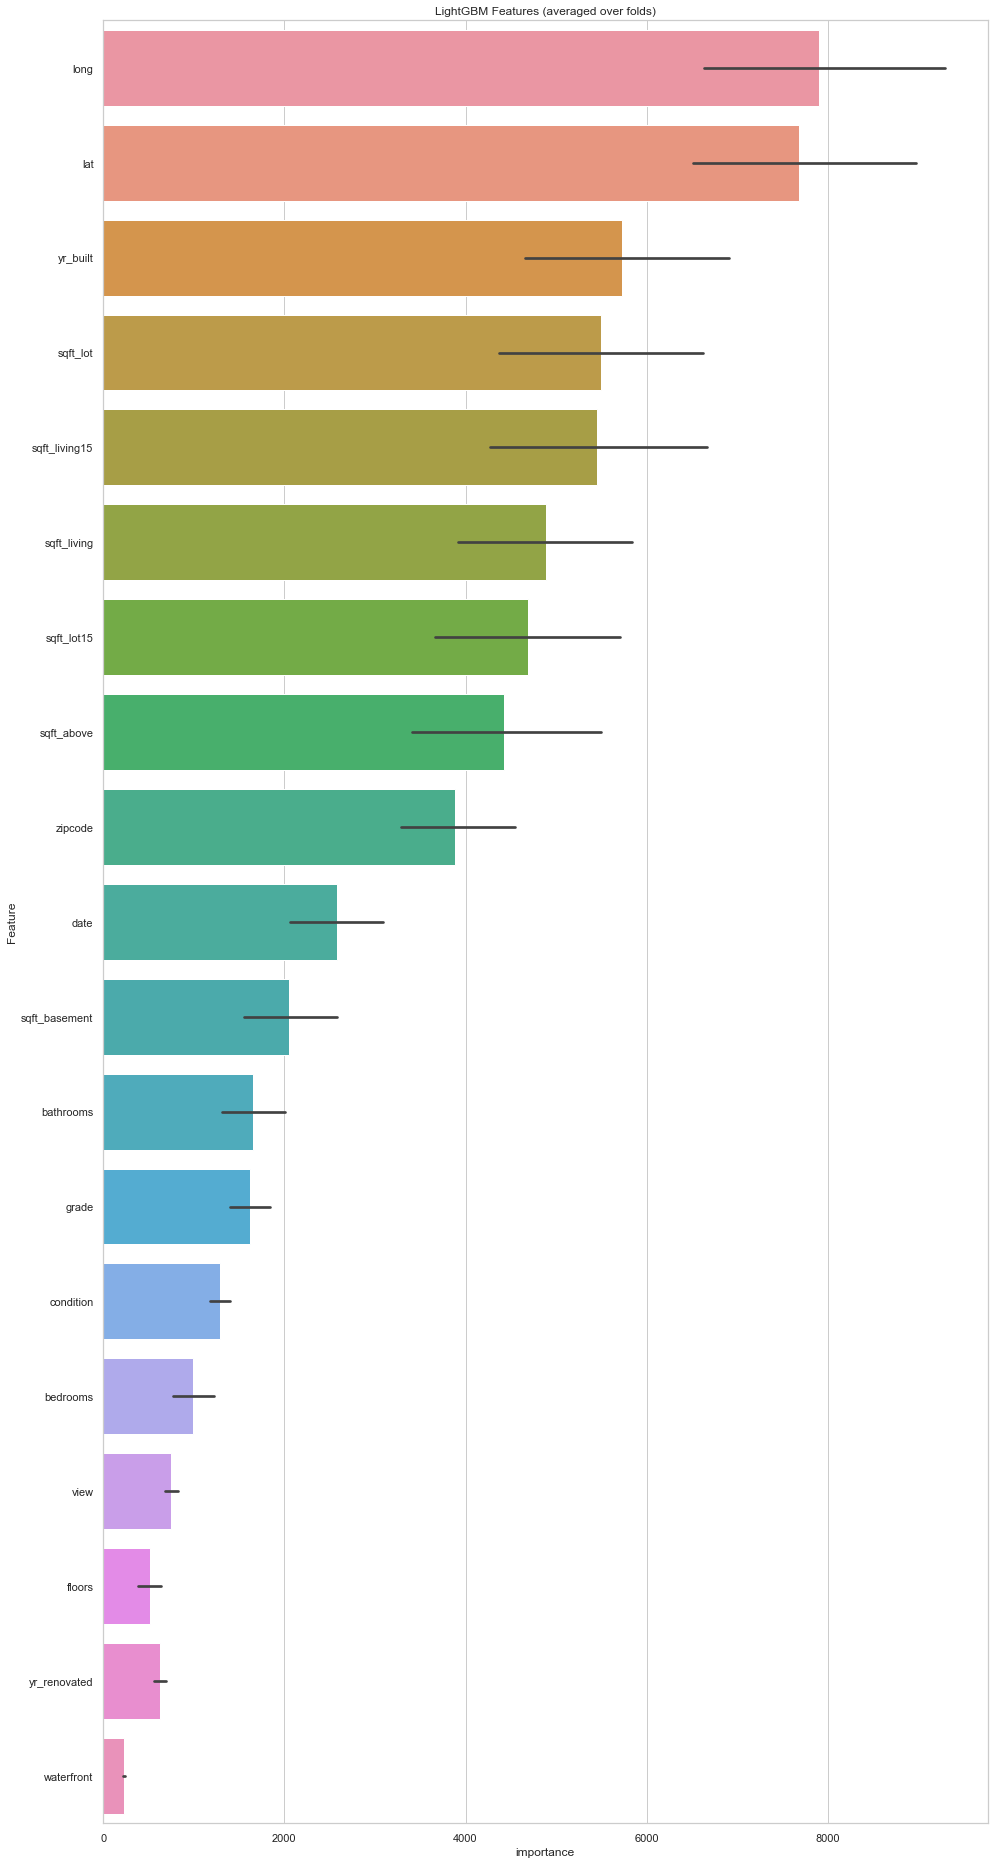

In [11]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [13]:
submission = pd.read_csv("../dataset/sample_submission.csv")
submission.tail()

,id,price
6463,21498,100000
6464,21499,100000
6465,21500,100000
6466,21501,100000
6467,21502,100000


In [14]:
submission['price'] = np.expm1(predictions)
submission.tail()

,id,price
6463,21498,251294.780236
6464,21499,406272.728445
6465,21500,466366.830459
6466,21501,307974.797541
6467,21502,439370.073791


In [15]:
submission.to_csv("13th_submission.csv", index=False)

---

In [132]:
# 본 모델링은 강천성님 kernel을 참고하였습니다.
# model blending
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [133]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(df_train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], df_train.values, target)), 
                                             kf=kfold))

In [134]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8867
Model XGBoost CV score : 0.8853
Model LightGBM CV score : 0.9030


In [135]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [137]:
y_pred = AveragingBlending(models, df_train, target, df_test)
y_pred = np.expm1(y_pred)

In [138]:
submission = pd.read_csv("../dataset/sample_submission.csv")
submission.tail()

submission['price'] = y_pred
submission.tail()

,id,price
6463,21498,234614.566423
6464,21499,437215.830819
6465,21500,429647.368650
6466,21501,341736.298632
6467,21502,426922.059588


In [139]:
submission.to_csv("11th_submission.csv", index=False) # lgb하나썼을때보다 오히려 성능 떨어짐

In [32]:
len(df_train.columns)

100

In [41]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=70)
df_train_low = pca1.fit_transform(df_train)
df_train_low = pd.DataFrame(df_train_low)
df_train = pd.concat([df_train, df_train_low], axis=1)

In [42]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler


param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 0,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 9999,
         "categorical_feature=name" : 'zipcode'
        }

y_reg = target

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.131162	valid_1's rmse: 0.168792
[1000]	training's rmse: 0.108902	valid_1's rmse: 0.165215
[1500]	training's rmse: 0.0929376	valid_1's rmse: 0.164281
[2000]	training's rmse: 0.0804231	valid_1's rmse: 0.163775
[2500]	training's rmse: 0.0701646	valid_1's rmse: 0.163498
Early stopping, best iteration is:
[2680]	training's rmse: 0.0669298	valid_1's rmse: 0.16341
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.131717	valid_1's rmse: 0.162722
[1000]	training's rmse: 0.109013	valid_1's rmse: 0.160728
Early stopping, best iteration is:
[1033]	training's rmse: 0.107787	valid_1's rmse: 0.160678
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.13073	valid_1's rmse: 0.167086
[1000]	training's rmse: 0.108157	valid_1's rmse: 0.16435
[1500]	training's rmse: 0.0922778	valid_1's rmse: 0.163825
[2000]	training's rmse: 0.0796936	valid_1's rm

In [43]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

118200.39200679232


In [44]:
submission = pd.read_csv("../dataset/sample_submission.csv")
submission.tail()

submission['price'] = np.expm1(predictions)
submission.tail()

submission.to_csv("13th_submission.csv", index=False)

---

---

---

### 2차 Modeling
- 기본 feature에 scaling해준게 10만 9천대...
    - feature : normalization
    - target : log-scaling
- 조금씩 추가해보자

In [231]:
df_train[df_train.sqft_living > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,2280000.0,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [232]:
df_train.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,201410,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv("../dataset/train.csv")
df_test = pd.read_csv("../dataset/test.csv")
df_train['date'] = df_train['date'].map(lambda x : int(x.split('T')[0][:6]))
df_test['date'] = df_test['date'].map(lambda x : int(x.split('T')[0][:6]))
df_train = df_train.loc[df_train.index != 8912, :] # outlier 제거
test_id = df_test.id
df_train.shape, df_test.shape

((15034, 21), (6468, 20))

In [150]:
# # 이상치 제거
# # 위에서 하나 제거(sqft_living기준 13000이상짜리 1개, id=8912)

# # ratio_total/total15
# # ratio_total/total15 > 70보다 큰 데이터 제거 (1개)
# df_train['total_area'] = df_train['sqft_living'] + df_train['sqft_lot']
# df_train['total_area15'] = df_train['sqft_living15'] + df_train['sqft_lot15']
# df_train['ratio_total/total15'] = df_train['total_area'] / df_train['total_area15']
# idx = df_train[df_train['ratio_total/total15'] > 70].index[0]
# df_train = df_train.loc[df_train.index != idx, :]

# # total area
# # 1500000이상 제거
# df_train['total_area'] = df_train['sqft_living'] + df_train['sqft_lot']
# idx = df_train[df_train.total_area > 1500000].index[0]
# df_train = df_train.loc[df_train.index != idx, :]

In [151]:
# df_train.drop(columns=['total_area','total_area15','ratio_total/total15'], inplace=True)

#### 1. distance를 추가하자 --> 10만 7700대
#### 2. 1(distance) + 47.5~47.7사이인지 여부를 추가하자 --> 10만 8천대
#### 3. 2(distance, 47.5~47.7) + 상위 25% 지역, 하위 25% 지역 binary category로 추가 --> 10만 7900대
#### 4. 1(distance) + 집 총 면적 추가 -->10만 8900대
#### 5. 1(distance) + PCA + K-means --> 10만 8900대 *cv는 1번보다 좋았다.
#### 6. 1(distance) + K-means --> 10만 9500대 
#### 7. outlier제거 + 1(distance) + above/floor ratio + sqft-feature log scaling --> 10만 6896대 *cv : 116424.83291074971(1번보다 안좋음)
#### 8. 7번 + normalization --> 10만 6600대 
#### 9. 7번 + etc featuren 추가 (grade + view + waterfront + condition) --> 10만 4125
#### 10 9번 + ratio_living/living15 --> 10만 5000대 ; feature를 다 때려박고 가장 importance가 높았던 feature인 living/living15추가한것임.

In [152]:
# # PCA 실시 : lat, long
# pca = PCA(n_components=2).fit(df_train[['lat','long']])
# temp_train = pca.transform(df_train[['lat','long']])
# df_train['pca_comp1'] = temp_train[:,0]
# df_train['pca_comp2'] = temp_train[:,1]

# temp_test = pca.transform(df_test[['lat','long']])
# df_test['pca_comp1'] = temp_test[:,0]
# df_test['pca_comp2'] = temp_test[:,1]

In [153]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5, random_state=42).fit(df_train[['lat','long']])
# coord_cluster_train = kmeans.predict(df_train[['lat','long']])
# coord_cluster_test = kmeans.predict(df_test[['lat','long']])
# df_train['cluster'] = coord_cluster_train 
# df_test['cluster'] = coord_cluster_test

In [154]:
def get_distance_from_max(train, test):
    """
    train set에서 가장 비싼 집과 떨어진 거리 계산
    """
    max_idx = train[train['price'] == train['price'].max()].index[0]
    max_location = np.array(train[['lat','long']].loc[max_idx,:]) # 가장 비싼 집의 좌표
    train_location = np.array(train[['lat','long']])
    test_location = np.array(test[['lat','long']])
    # compute distance : ||location1 - location2||
    distance_from_max_train = sp.linalg.norm(max_location - train_location, axis=1)
    distance_from_max_test = sp.linalg.norm(max_location - test_location, axis=1)
    return distance_from_max_train, distance_from_max_test

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# def make_normal(train, test, cols):
#     """
#     평균0으로 scaling (standardization)
#     train의 평균, 표준편차 사용하여 test noramlize!!
#     대상 columns : ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']
#     혹시 있을지 모를 outlier의 영향을 최소화하기 위해 RobustScaler활용
#     """
#     # mean_ls = list(train[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'lat', 'long']].mean(axis=0))
#     standardScaler = StandardScaler()
# #     robustScaler = RobustScaler()
#     standardScaler.fit(train[cols])
#     temp1 = standardScaler.transform(train[cols])
#     temp1 = pd.DataFrame(data=temp1,columns=cols, dtype=np.float32)
#     df1 = train.drop(columns=cols)
#     df_train = pd.concat([df1, temp1], axis=1)
    
#     temp2 = standardScaler.transform(test[cols])
#     temp2 = pd.DataFrame(data=temp2, columns=cols ,dtype=np.float32)
#     df2 = test.drop(columns=cols)
#     df_test = pd.concat([df2, temp2], axis=1)
    
#     return df_train, df_test

def make_normal(train, test, cols):

    standardScaler = StandardScaler()
    standardScaler.fit(train[cols])
    train[cols] = standardScaler.transform(train[cols])
    
    test[cols] = standardScaler.transform(test[cols])
    
    return train, test

def feature_logscaling(train, test, scaling_cols):
    
    for col in scaling_cols:
        train[col] = np.log1p(train[col])
        test[col] = np.log1p(test[col])
    
    return train, test 

def target_logscaling(train):
    train['log_price'] = np.log1p(train['price'])
    return train

def column_selection(train, drop_cols):
    cols = list(train.columns)
    for drop_col in drop_cols:
        if drop_col in cols:
            idx = cols.index(drop_col)
            cols.pop(idx)
    
    return cols
####################################################################################################################################

df_train['distance_from_max'], df_test['distance_from_max'] = get_distance_from_max(df_train, df_test)

# df_train['is_center'] = df_train['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)
# df_test['is_center'] = df_test['lat'].map(lambda x : 1 if x > 47.5 and x < 47.7 else 0)

# df_train['over25%'] = df_train['zipcode'].map(lambda x : 1 if (x==98004) or (x==98005) or (x==98007) or (x==98008) or (x==98007) or (x==98040) or (x==98074) or (x==98075) else 0)
# df_test['over25%'] = df_test['zipcode'].map(lambda x : 1 if (x==98004) or (x==98005) or (x==98007) or (x==98008) or (x==98007) or (x==98040) or (x==98074) or (x==98075) else 0)
# df_train['under25%'] = df_train['zipcode'].map(lambda x : 1 if (x==98070) or (x==98108) or (x==98109) or (x==98168) else 0)
# df_test['under25%'] = df_test['zipcode'].map(lambda x : 1 if (x==98070) or (x==98108) or (x==98109) or (x==98168) else 0)

# df_train['total_area'] = df_train['sqft_living'] + df_train['sqft_lot']
# df_test['total_area'] = df_test['sqft_living'] + df_test['sqft_lot']

# df_train['total_area15'] = df_train['sqft_living15'] + df_train['sqft_lot15']
# df_test['total_area15'] = df_test['sqft_living15'] + df_test['sqft_lot15']

# above와 basement의 비율
# df_train['ratio_above/living'] = np.log1p(df_train['sqft_above'] / df_train['sqft_living'])
# df_train['ratio_basement/living'] = np.log1p(df_train['sqft_basement'] / df_train['sqft_living'])

# df_test['ratio_above/living'] = np.log1p(df_test['sqft_above'] / df_test['sqft_living'])
# df_test['ratio_basement/living'] = np.log1p(df_test['sqft_basement'] / df_test['sqft_living'])

# # 면적의 차이 : sqft_living - sqft_living15, sqft_lot - sqft_lot15
# df_train['living_diff'] = df_train['sqft_living'] - df_train['sqft_living15']
# df_test['living_diff'] = df_test['sqft_living'] - df_test['sqft_living15']

# # sqft_living / sqft_lot : 부지면적대비 주거면적의 비율
# df_train['ratio_living/lot'] = np.log1p(df_train['sqft_living'] / df_train['sqft_lot'])
# df_test['ratio_living/lot'] = np.log1p(df_test['sqft_living'] / df_test['sqft_lot'])

# sqft_living / sqft_living15, sqft_lot / sqft_lot15

df_train['ratio_living/living15'] = np.log1p(df_train['sqft_living'] / df_train['sqft_living15'])
# df_train['ratio_lot/lot15'] = np.log1p(df_train['sqft_lot'] / df_train['sqft_lot15'])

df_test['ratio_living/living15'] = np.log1p(df_test['sqft_living'] / df_test['sqft_living15'])
# df_test['ratio_lot/lot15'] = np.log1p(df_test['sqft_lot'] / df_test['sqft_lot15'])

# # total ratio : total / total15
# df_train['ratio_total/total15'] = df_train['total_area'] / df_train['total_area15']
# df_test['ratio_total/total15'] = df_test['total_area'] / df_test['total_area15']


# # bathrooms + bedrooms : 총 구성
# df_train['bath+bed'] = df_train['bathrooms'] + df_train['bedrooms']
# df_test['bath+bed'] = df_test['bathrooms'] + df_test['bedrooms']

# waterfront + view + condition
df_train['etc'] = df_train['grade'] + df_train['waterfront'] + df_train['view'] + df_train['condition']
df_test['etc'] = df_test['grade'] + df_test['waterfront'] + df_test['view'] + df_test['condition']

# sqft_above / floor 
df_train['ratio_above/floors'] = df_train['sqft_above'] / df_train['floors']
df_test['ratio_above/floors'] = df_test['sqft_above'] / df_test['floors']

# feature : log scaling + normalization
# scaling_cols = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15',
#                 'sqft_lot15','ratio_above/floors','total_area','total_area15','ratio_above/living','ratio_basement/living',
#                 'ratio_living/lot','ratio_living/living15','ratio_lot/lot15','ratio_total/total15']
scaling_cols = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15',
                'sqft_lot15','ratio_above/floors','ratio_living/living15']
df_train, df_test = feature_logscaling(df_train, df_test, scaling_cols)
df_train, df_test = make_normal(df_train, df_test, 
                               cols=scaling_cols)
df_train = target_logscaling(df_train)

In [155]:
training_cols = column_selection(df_train, drop_cols=['id','log_price','price'])
target = df_train['log_price']
df_train, df_test = df_train[training_cols], df_test[training_cols]

In [156]:
df_train.tail()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance_from_max,ratio_living/living15,etc,ratio_above/floors
15030,201410,4,2.50,0.658695,-0.319283,2.0,0,0,3,9,...,0,98056,47.5137,-122.167,0.881902,-0.317699,0.194461,-0.063219,12,0.227710
15031,201503,4,3.50,1.437445,-0.122151,2.0,0,0,3,9,...,0,98136,47.5537,-122.398,0.254168,-0.282085,0.106847,1.941913,12,0.313614
15032,201405,3,2.50,-0.513818,-2.165883,3.0,0,0,3,8,...,0,98103,47.6993,-122.346,-0.635451,-2.019287,0.073207,-0.063219,11,-2.257090
15033,201502,4,2.50,0.454218,-0.358477,2.0,0,0,3,8,...,0,98146,47.5107,-122.362,-0.091039,-0.098220,0.125323,0.788305,11,-0.011445
15034,201410,2,0.75,-1.466289,-2.220898,2.0,0,0,3,7,...,0,98144,47.5941,-122.299,-1.868047,-2.149764,0.043017,-0.063219,10,-2.257090


In [157]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler


param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 0,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 9999,
         "categorical_feature=name" : 'zipcode'
        }

y_reg = target

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test, num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.139106	valid_1's rmse: 0.16368
[1000]	training's rmse: 0.121473	valid_1's rmse: 0.159694
[1500]	training's rmse: 0.109523	valid_1's rmse: 0.158668
Early stopping, best iteration is:
[1787]	training's rmse: 0.103873	valid_1's rmse: 0.158387
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.13977	valid_1's rmse: 0.159051
[1000]	training's rmse: 0.121934	valid_1's rmse: 0.155662
[1500]	training's rmse: 0.109906	valid_1's rmse: 0.155213
[2000]	training's rmse: 0.100338	valid_1's rmse: 0.155005
Early stopping, best iteration is:
[1940]	training's rmse: 0.101401	valid_1's rmse: 0.154947
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.138281	valid_1's rmse: 0.167538
[1000]	training's rmse: 0.120602	valid_1's rmse: 0.164626
Early stopping, best iteration is:
[1355]	training's rmse: 0.111782	valid_1's rmse: 0.163955
Training until 

In [158]:
# only distance = 116250.94801079197
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

116517.29555264804


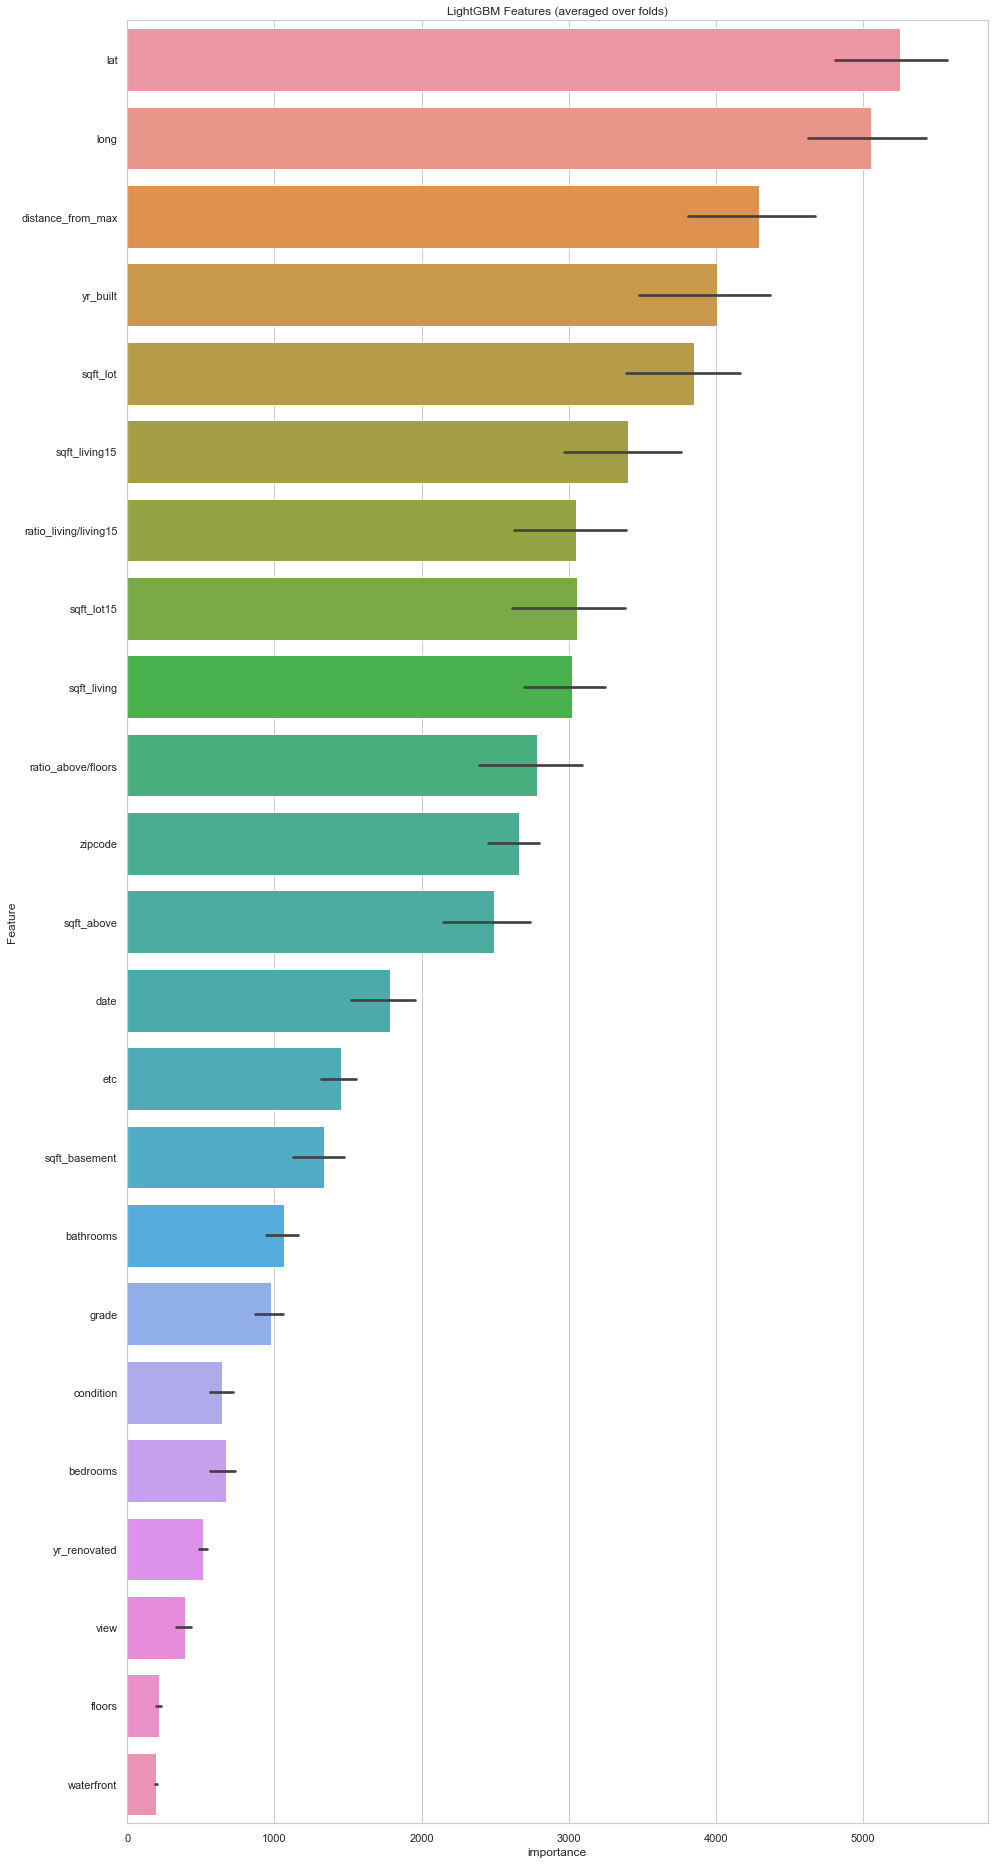

In [159]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()

In [160]:
submission = pd.read_csv("../dataset/sample_submission.csv")
submission.tail()

submission['price'] = np.expm1(predictions)
submission.tail()

submission.to_csv("28th_submission.csv", index=False)